Can experience and age predict hours played?

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
set.seed(2020)

In [4]:
players <- read_csv('players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
players_tidy <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    # filter(100 > played_hours) |>
    select(experience, Age, played_hours)
players_tidy

experience,Age,played_hours
<dbl>,<dbl>,<dbl>
5,9,30.3
4,17,3.8
4,17,0.0
2,21,0.7
3,21,0.1
2,17,0.0
3,19,0.0
2,21,0.0
2,17,0.1


In [6]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_hours = mean(played_hours))
experience_playtime_means

experience,mean_player_hours
<dbl>,<dbl>
1,1.2485714
2,6.0174603
3,18.7257143
4,0.6479167
5,2.7846154


In [7]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<dbl>,<dbl>
1,21.65714
2,20.25397
3,20.60000
4,20.95833
5,16.92308


In [8]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [9]:
players_recipe <- recipe(played_hours ~ experience + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
gridvals <- tibble(neighbors = seq(from = 1, to = 109, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,16.52910,5,5.636982,Preprocessor1_Model001
2,rmse,standard,13.74532,5,4.596021,Preprocessor1_Model002
3,rmse,standard,12.99159,5,4.666013,Preprocessor1_Model003
4,rmse,standard,12.44441,5,4.598110,Preprocessor1_Model004
5,rmse,standard,12.35063,5,4.631707,Preprocessor1_Model005
6,rmse,standard,12.61553,5,4.493469,Preprocessor1_Model006
7,rmse,standard,12.22485,5,4.578884,Preprocessor1_Model007
8,rmse,standard,12.19256,5,4.564132,Preprocessor1_Model008
9,rmse,standard,12.15157,5,4.560228,Preprocessor1_Model009


In [13]:
players_min <- players_results |>
    filter(mean == min(mean))
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
62,rmse,standard,11.83862,5,4.405211,Preprocessor1_Model062


In [14]:
players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 62) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,50.94527


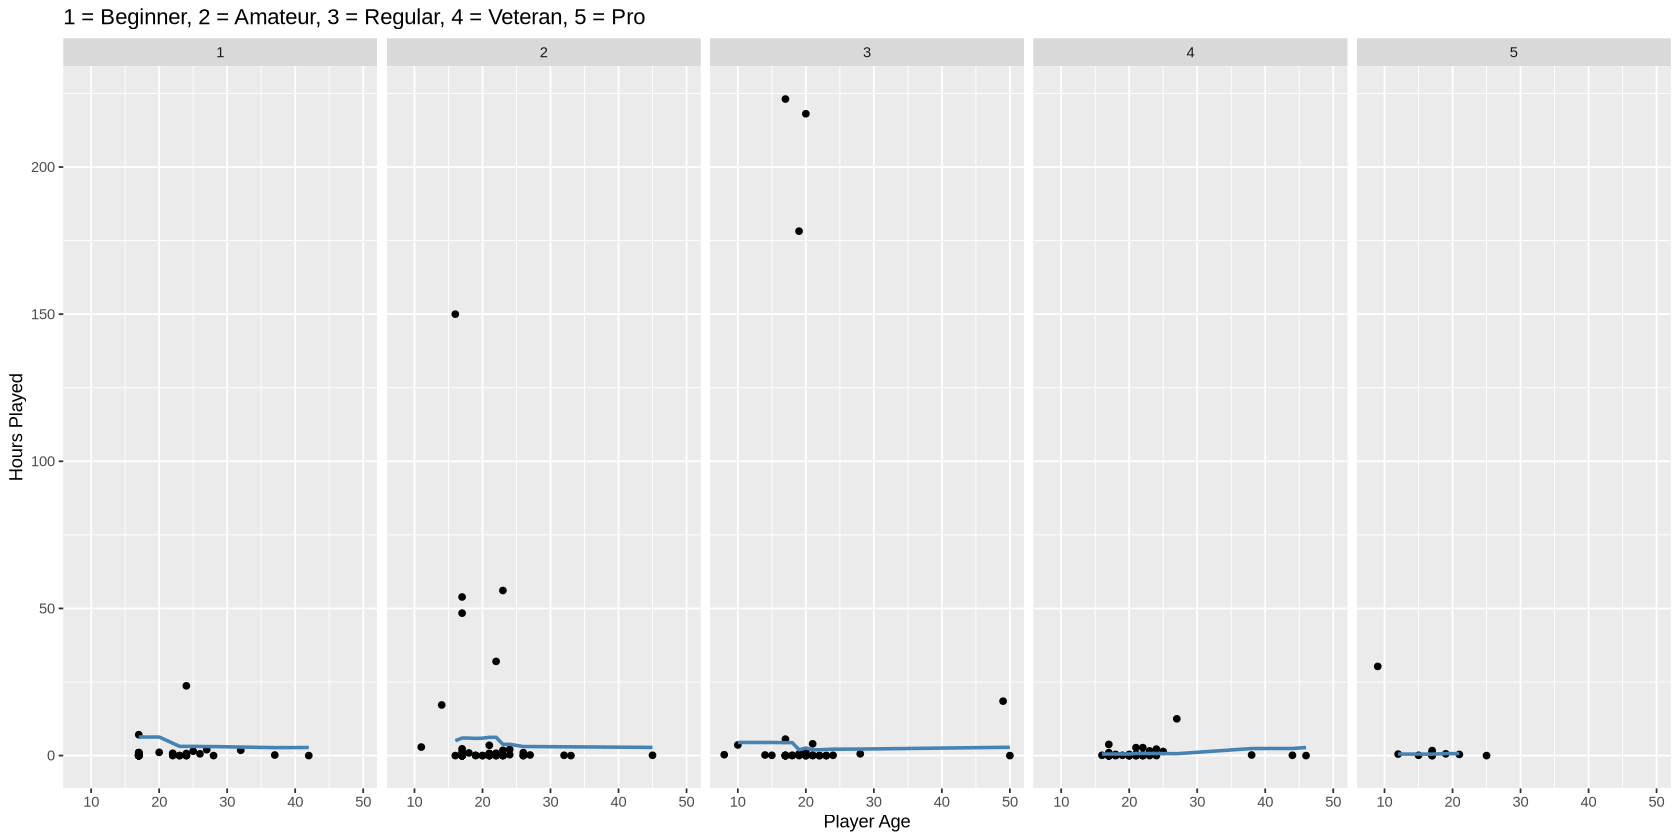

In [15]:
players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_hours)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot + facet_wrap(~experience, ncol = 5)

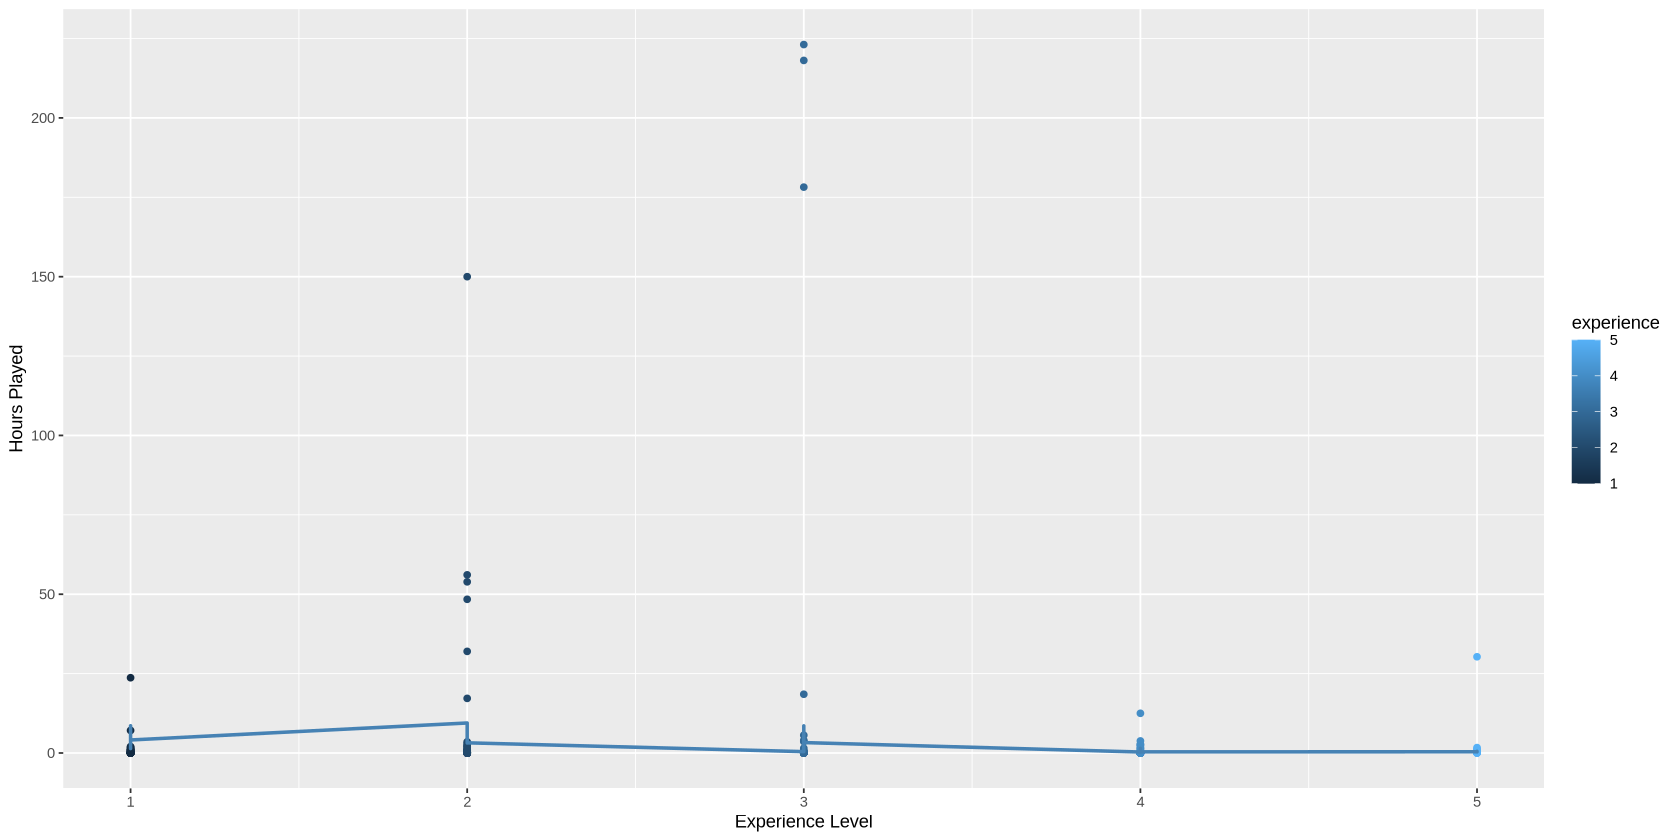

In [13]:
players_experience_plot <- ggplot(players_tidy, aes(x = experience, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = experience, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Experience Level") +
  ylab("Hours Played")

players_experience_plot

In [14]:
players_preds #|>
    group_by(Age) |>
    summarize(mean_ph = mean(played_hours)) |>
    arrange(Age)

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
0.3064516,4,17,0.0
9.4483871,2,17,0.0
0.4290323,3,19,0.0
6.5032258,2,21,0.0
9.4483871,2,17,0.1
0.4064516,4,22,0.0
0.3838710,5,17,0.0
3.2032258,2,22,0.0
8.5838710,1,17,0.0


ERROR: Error in eval(expr, envir, enclos): object 'Age' not found


In [15]:
regulars <- players_tidy |>
    filter(experience == 'Regular')

regulars_split <- initial_split(regulars, prop = 0.75, strata = played_hours)
regulars_train <- training(regulars_split)
regulars_test <- testing(regulars_split)

regulars_recipe <- recipe(played_hours ~ Age, data = regulars_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

regulars_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

regulars_vfold = vfold_cv(regulars_train, v = 5, strata = played_hours)

regulars_workflow <- workflow() |>
    add_recipe(regulars_recipe) |>
    add_model(regulars_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

regulars_results <- regulars_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
regulars_min <- regulars_results |>
    filter(mean == min(mean))
regulars_min

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


ERROR: [1m[33mError[39m in `tibble::tibble()`:[22m
[1m[22m[33m![39m Tibble columns must have compatible sizes.
[36m•[39m Size 2: Existing data.
[36m•[39m Size 0: Column `strata`.
[36mℹ[39m Only values of size one are recycled.


In [16]:
regulars

experience,Age,played_hours
<dbl>,<dbl>,<dbl>


In [ ]:
players_real <- players_tidy |>
    filter(played_hours != 0)

players_real_split <- initial_split(players_real, prop = 0.75, strata = played_hours)
players_real_train <- training(players_real_split)
players_real_test <- testing(players_real_split)

players_real_recipe <- recipe(played_hours ~ Age, data = players_real_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_real_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_vfold = vfold_cv(players_real_train, v = 5, strata = played_hours)

players_real_workflow <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 32, by = 1))

players_real_results <- players_real_workflow |>
  tune_grid(resamples = players_real_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_real_min <- players_real_results |>
    filter(mean == min(mean))
players_real_min

In [ ]:
players_real_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 24) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_fit <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec) |>
    fit(data = players_real_train)

players_real_summary <- players_real_fit |>
  predict(players_real_test) |>
  bind_cols(players_real_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_real_summary

In [ ]:
players_real_preds <- predict(players_real_fit, players_real_train) |>
        bind_cols(players_real_train)

players_real_plot <- ggplot(players_real, aes(x = Age, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_real_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played")

players_real_plot

In [ ]:
players_real_preds |>
    arrange(Age)